In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import gensim

from collections import Counter
 
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import warnings

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Basic BERT

In [ ]:
import pandas as pd
import numpy as np

import seaborn as sns

import torch
from transformers import BertTokenizer, BertModel

# OPTIONAL: if you want to have more information on what's happening, activate the logger as follows
import logging
#logging.basicConfig(level=logging.INFO)

import matplotlib.pyplot as plt
% matplotlib inline

# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')



/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
text = "A band is a musical group but a band is also a ring you put on your finger"

marked_text = "[CLS] " + text + " [SEP]"

# Satz tokenisieren
tokenized_text = tokenizer.tokenize(marked_text)

# Token strings und Vokabular Indexe verbinden
indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
segments_ids = [1] * len(tokenized_text)

# Tensoren erstellen
tokens_tensor = torch.tensor([indexed_tokens])
segments_tensors = torch.tensor([segments_ids])

# vortrainiertes Modell laden
model = BertModel.from_pretrained('bert-base-uncased',
                                  output_hidden_states = True,
                                  )

In [ ]:
# Load pre-trained model (weights)
model = BertModel.from_pretrained('bert-base-uncased',
                                  output_hidden_states = True, # Whether the model returns all hidden-states.
                                  )

# Put the model in "evaluation" mode, meaning feed-forward operation.
model.eval()



In [ ]:
# Run the text through BERT, and collect all of the hidden states produced
# from all 12 layers. 
with torch.no_grad():

    outputs = model(tokens_tensor, segments_tensors)

    # Evaluating the model will return a different number of objects based on 
    # how it's  configured in the `from_pretrained` call earlier. In this case, 
    # becase we set `output_hidden_states = True`, the third item will be the 
    # hidden states from all layers. See the documentation for more details:
    # https://huggingface.co/transformers/model_doc/bert.html#bertmodel
    hidden_states = outputs[2]


In [ ]:
token_embeddings = torch.stack(hidden_states, dim=0)

token_embeddings = torch.squeeze(token_embeddings, dim=1)

token_embeddings = token_embeddings.permute(1,0,2)

token_embeddings.size()

In [ ]:
# Stores the token vectors, with shape [22 x 768]
token_vecs_sum = []

# `token_embeddings` is a [22 x 12 x 768] tensor.

# For each token in the sentence...
for token in token_embeddings:

    # `token` is a [12 x 768] tensor

    # Sum the vectors from the last four layers.
    sum_vec = torch.sum(token[-4:], dim=0)
    
    # Use `sum_vec` to represent `token`.
    token_vecs_sum.append(sum_vec)

print ('Shape is: %d x %d' % (len(token_vecs_sum), len(token_vecs_sum[0])))



# Sentence Transformers

https://github.com/UKPLab/sentence-transformers

In [2]:
!pip install -U sentence-transformers

     |████████████████████████████████| 71kB 2.0MB/s 
     |████████████████████████████████| 778kB 8.1MB/s 
     |████████████████████████████████| 890kB 33.7MB/s 
     |████████████████████████████████| 3.0MB 42.5MB/s 
     |████████████████████████████████| 1.1MB 45.9MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-0.3.3-cp36-none-any.whl size=97299 sha256=abb69a5a71bb17ef3bdd2cd891f86c559b6462048d3dd54484bc0f672a30c244
  Stored in directory: /root/.cache/pip/wheels/75/d6/0a/cab163b21d0597cc1580bc344487b11ad405e0d1d314725f2b
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=8e2f10b2803afab49544df49ea5e1016e99a6e4c7226035ce4f7511f82642b47
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sentence-transformers sacremoses


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
songs = pd.read_csv('/content/drive/My Drive/song_decades_long.csv')
songs = songs[songs.Genre1!='Rock']
songs = songs[songs.Genre1!='Pop']
songs.head()

,Unnamed: 0,artist,decades,text,stemmed_text,POS,Genre1,genre1,number_of_tokens,number_of_types
4,81,*NSYNC,1990s,here we go here we go one more time eve...,here we go here we go one more time everybodi...,fine fine free right fine right fine free time...,Electronic,boy band,1786.0,345.0
5,87,*NSYNC,2000s,this is the time of year that we learn to giv...,thi is the time of year that we learn to give...,true hard alone dark true true true time year ...,Electronic,boy band,3700.0,548.0
6,98,*NSYNC,2010s,girl don't say that it's over 'cause you are ...,girl do n't say that it 's over 'caus you are...,wrong lonely beautiful beautiful beautiful bea...,Electronic,boy band,1499.0,299.0
31,395,Alison Krauss,1990s,when god dips his pen of love in my heart and...,when god dip hi pen of love in my heart and h...,sinful whole sinful dreary dark cold unburdene...,"Folk, World, & Country",bluegrass,1689.0,369.0
32,402,Alison Krauss,2000s,tonight i waited but my heart is so cold 'ca...,tonight i wait but my heart is so cold 'caus ...,cold other loving tonight heart minute job chi...,"Folk, World, & Country",bluegrass,1318.0,371.0


In [5]:
train, test = train_test_split(songs, test_size=0.2)

In [6]:
train_lyrics = list(train.stemmed_text)
test_lyrics = list(test.stemmed_text)
len(train_lyrics), len(test_lyrics)

(203, 51)

In [7]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('bert-base-nli-mean-tokens')
# auch roberta oder distilbert möglich

100%|██████████| 405M/405M [00:18<00:00, 21.7MB/s]


In [89]:
sentence_embeddings = model.encode(train_lyrics)

In [96]:
for sentence, embedding in zip(train_lyrics[:2], sentence_embeddings[:2]):
  print(sentence,'\n', embedding[:10])

 who ride ? we ride ! who ride we ride ! on three we ride 1 2 3 we ride ! 1 2 3 we ride ! beat up on yo pad come on lill homi go on beat up yo pad you love footbal beat up on yo pad if your down with snoop dogg beat up onyo pad beat up on yo pad come on lill homi go on beat up yo pad if your run the ball speed up on em fast ai n't no need to play with emjust beat up on yo pad they bang everi saturday and sunday loc syfl man it ai n't no joke helmet and shoulder pad ai n't no bullet proof vest see there ai n't to mani option in the wild wild west so i 've been bless so i guess i can give back footbal in the hood dog you did that i brought the demo back and that 's just one i 'm in the one where the steeler come and get some want some bad enough take it run back dip and cut shake it you ai n't get none insid out hit that 8 i love it when they say that who 's hous c hous g hous b hous d hous well we hous wherev we go blow them out let them know that you could shine it all for the kid plu 

# Evaluieren

#### "Scharfes Hinsehen"

In [78]:
def assign_genre_combination(df):
  for i, row in df.iterrows():
    genre = df.iloc[0,6]
    # print((df.iloc[i,6]))
    df.at[i, 'genre_comb'] = str(genre)+'_'+str(row.Genre1)
  return df

In [97]:
import random
# Pick a random document from the test corpus and infer a vector from the model
doc_id = random.randint(0, len(test.stemmed_text) - 1)
query = test.iloc[doc_id].stemmed_text
query

" i wa runnin ' through the summer rain tri ' n ' to catch that evenin ' train and kill the old familiar pain weavin ' through my tangl brain when i tip my bottl back and smack into a cop i did n't see that polic man said `` mister cool if you ai n't drunk then you 're a fool . '' i said `` if that 's against the law then tell me whi i never saw a man lock in that jail of your who wa n't neither black or poor as me ? '' well that wa when someon turn out the light and i wound up in jail to spend the night and dream of all the wine and lone girl in thi best of all possibl world . well i woke up next mornin ' feelin ' like my head wa gone and like my thick old tongu wa lickin ' someth sick and wrong and i told that man i 'd sell my soul for someth wet and cold as that old cell . that kindli jailer grin at me all eaten up with sympathi then pour himself anoth beer and came and whisper in my ear `` if booz wa just a dime a bottl boy you could n't even buy the smell '' i said `` i knew there

In [98]:
import scipy
query = query #@param {type: 'string'}

queries = [query]
query_embeddings = model.encode(queries)

# Find the closest 3 sentences of the corpus for each query sentence based on cosine similarity
number_top_matches = 9 #@param {type: "number"}

print("Semantic Search Results")
most_similar = pd.DataFrame()
distances = []
for query, query_embedding in zip(queries, query_embeddings):
    distance = scipy.spatial.distance.cdist([query_embedding], sentence_embeddings, "cosine")[0]

    results = zip(range(len(distance)), distance)
    results = sorted(results, key=lambda x: x[1])
    
    print("\n\n======================\n\n")
    print("Query:", query)
    print("\nTop 9 most similar sentences in corpus:")
    # most_similar = pd.concat([most_similar,songs[songs.stemmed_text==query]])

    for idx, dist in results[0:number_top_matches]:
        distances.append(dist)

        print(lyrics[idx].strip(), "(Cosine Score: %.4f)" % (1-dist), '\n')
        most_similar = pd.concat([most_similar,songs[songs.stemmed_text==lyrics[idx]]])
print(len(distances), distances)
most_similar['similarity'] = distances
most_similar = assign_genre_combination(most_similar)
most_similar


Semantic Search Results




Query:  i wa runnin ' through the summer rain tri ' n ' to catch that evenin ' train and kill the old familiar pain weavin ' through my tangl brain when i tip my bottl back and smack into a cop i did n't see that polic man said `` mister cool if you ai n't drunk then you 're a fool . '' i said `` if that 's against the law then tell me whi i never saw a man lock in that jail of your who wa n't neither black or poor as me ? '' well that wa when someon turn out the light and i wound up in jail to spend the night and dream of all the wine and lone girl in thi best of all possibl world . well i woke up next mornin ' feelin ' like my head wa gone and like my thick old tongu wa lickin ' someth sick and wrong and i told that man i 'd sell my soul for someth wet and cold as that old cell . that kindli jailer grin at me all eaten up with sympathi then pour himself anoth beer and came and whisper in my ear `` if booz wa just a dime a bottl boy you could n't even buy t

,Unnamed: 0,artist,decades,text,stemmed_text,POS,Genre1,genre1,number_of_tokens,number_of_types,similarity,genre_comb
477,6276,Kris Kristofferson,1970s,i was runnin' through the summer rain try'n' ...,i wa runnin ' through the summer rain tri ' n...,old familiar tangled cool drunk black poor lon...,"Folk, World, & Country",country rock,2652.0,871.0,0.000000,"Folk, World, & Country_Folk, World, & Country"
910,11846,Townes Van Zandt,1960s,the drunken clown's still hanging round but i...,the drunken clown 's still hang round but it ...,drunken hard blind sure worth closed first nat...,"Folk, World, & Country",alternative country,1364.0,545.0,0.167112,"Folk, World, & Country_Folk, World, & Country"
187,2394,Donna Summer,2010s,it's raining it's pouring my lovelife is bor...,it 's rain it 's pour my lovelif is bore me t...,perfect other enough enough enough enough enou...,Electronic,dance pop,1287.0,217.0,0.168441,"Folk, World, & Country_Electronic"
478,6288,Kris Kristofferson,2000s,billy dee was seventeen when he turned twenty-...,billi dee wa seventeen when he turn twenty-on...,foolish high crazy free lucky busy own own cra...,"Folk, World, & Country",country rock,2024.0,663.0,0.179598,"Folk, World, & Country_Folk, World, & Country"
415,5366,Johnny Cash,2000s,to the town of agua fria rode a stranger one f...,to the town of agua fria rode a stranger one ...,fine much big big early south loose big big ma...,"Folk, World, & Country",arkansas country,3992.0,983.0,0.182080,"Folk, World, & Country_Folk, World, & Country"
803,10542,Sublime,2000s,boo boo boo take a look at you hangin' on th...,boo boo boo take a look at you hangin ' on th...,third daisy crazy perfect okay perfect perfect...,Electronic,reggae fusion,1226.0,377.0,0.186588,"Folk, World, & Country_Electronic"
453,5942,Kenny Chesney,2000s,i'd spent a lot more time in the pouring rain ...,i 'd spent a lot more time in the pour rain c...,skinny different alive afraid different red ba...,"Folk, World, & Country",contemporary country,10328.0,1704.0,0.191502,"Folk, World, & Country_Folk, World, & Country"
384,4901,Jeezy,2000s,what they want? they want that young shit th...,what they want ? they want that young shit th...,young dumb conscious correctional vegetable li...,Hip Hop,atl hip hop,16766.0,2739.0,0.196043,"Folk, World, & Country_Hip Hop"
413,5346,Johnny Cash,1970s,i was just a kid roamin' around travelin' thro...,i wa just a kid roamin ' around travelin ' th...,kid little ol' broke vagrancy great big dead f...,"Folk, World, & Country",arkansas country,3277.0,897.0,0.213358,"Folk, World, & Country_Folk, World, & Country"


In [99]:
most_similar.drop('number_of_tokens', axis=1, inplace=True)
most_similar.drop('Unnamed: 0', axis=1, inplace=True)
most_similar.drop('text', axis=1, inplace=True)
most_similar.drop('number_of_types', axis=1, inplace=True)
most_similar.drop('POS', axis=1, inplace=True)
most_similar

,artist,decades,stemmed_text,Genre1,genre1,similarity,genre_comb
477,Kris Kristofferson,1970s,i wa runnin ' through the summer rain tri ' n...,"Folk, World, & Country",country rock,0.000000,"Folk, World, & Country_Folk, World, & Country"
910,Townes Van Zandt,1960s,the drunken clown 's still hang round but it ...,"Folk, World, & Country",alternative country,0.167112,"Folk, World, & Country_Folk, World, & Country"
187,Donna Summer,2010s,it 's rain it 's pour my lovelif is bore me t...,Electronic,dance pop,0.168441,"Folk, World, & Country_Electronic"
478,Kris Kristofferson,2000s,billi dee wa seventeen when he turn twenty-on...,"Folk, World, & Country",country rock,0.179598,"Folk, World, & Country_Folk, World, & Country"
415,Johnny Cash,2000s,to the town of agua fria rode a stranger one ...,"Folk, World, & Country",arkansas country,0.182080,"Folk, World, & Country_Folk, World, & Country"
803,Sublime,2000s,boo boo boo take a look at you hangin ' on th...,Electronic,reggae fusion,0.186588,"Folk, World, & Country_Electronic"
453,Kenny Chesney,2000s,i 'd spent a lot more time in the pour rain c...,"Folk, World, & Country",contemporary country,0.191502,"Folk, World, & Country_Folk, World, & Country"
384,Jeezy,2000s,what they want ? they want that young shit th...,Hip Hop,atl hip hop,0.196043,"Folk, World, & Country_Hip Hop"
413,Johnny Cash,1970s,i wa just a kid roamin ' around travelin ' th...,"Folk, World, & Country",arkansas country,0.213358,"Folk, World, & Country_Folk, World, & Country"


In [106]:
def most_similar_doc(songs, sims, train_tagged):
  match = []
  similarity = []
  for i, row in songs_all.iterrows():
    for res in get_doc_index(sims, train_tagged):
      if res[1]==row.stemmed_split:
        match.append(row)
        similarity.append(res[2])
  match_df = pd.DataFrame(match)
  match_df['similarity'] = similarity
  match_df.sort_values(by=['similarity'], inplace=True, ascending=False)
  match_df = match_df.reset_index()
  # print(match_df)
  match_df = assign_genre_combination(match_df)

  return match_df

In [118]:
query_embeddings = model.encode(test_lyrics)

In [129]:
# Find the closest 3 sentences of the corpus for each query sentence based on cosine similarity
number_top_matches = len(test_lyrics) 

print("Semantic Search Results")
match = pd.DataFrame()
for query, query_embedding in zip(test_lyrics, query_embeddings):
  most_similar = pd.DataFrame()
  distances = []

  distance = scipy.spatial.distance.cdist([query_embedding], sentence_embeddings, "cosine")[0]

  results = zip(range(len(distance)), distance)
  results = sorted(results, key=lambda x: x[1])

  print("\n\n======================\n\n")
  print("Query:", query)
  print("\nTop 9 most similar sentences in corpus:")
  # most_similar = pd.concat([most_similar,songs[songs.stemmed_text==query]])

  for idx, dist in results[0:number_top_matches]:
    distances.append(dist)

    # print(lyrics[idx].strip(), "(Cosine Score: %.4f)" % (1-dist), '\n')
    most_similar = pd.concat([most_similar,songs[songs.stemmed_text==lyrics[idx]]])
  print(len(most_similar), len(distances))
  most_similar['similarity'] = distances
  most_similar = assign_genre_combination(most_similar)
  match = pd.concat([match, most_similar])

Semantic Search Results




Query:  we 'd like to welcom y'all to the fabul carolina west i own thi motherfuck and my name is taa-dow y'all nigga know who i am y'all nigga tear up shit but we got someth old and someth new for y'all tonight put your hand togeth for snoop doggi dogg the dogg pound and the fabul dramat [ snoop doggi dogg ] it 's like everywher i look and everywher i go i 'm hear motherfuck tri to steal my flow but it ai n't no thing caus see my nigga coolio put me up on the game when i step through the do ' ya know some of these nigga is so decept use my style like a contracept i hope ya get burnt it seem ya have n't learnt it 's the nick nack patti wack i still got the bigger sack so put your gun away run away 'caus i 'm back whi ? hit em up get em up spit em up now tell me what 's go on it make me want to holler 'caus my dollar come in ozon lone for the break-up so take off your cloth and quit tri to spit at my motherfuck hoe seak of hoe i 'll get to the point you think

In [130]:
len(match)

2601

In [132]:
match.drop('number_of_tokens', axis=1, inplace=True)
match.drop('Unnamed: 0', axis=1, inplace=True)
match.drop('text', axis=1, inplace=True)
match.drop('number_of_types', axis=1, inplace=True)
match.drop('POS', axis=1, inplace=True)
print(len(match))
match

2601


,artist,decades,stemmed_text,Genre1,genre1,similarity,genre_comb
775,Snoop Dogg,1990s,we 'd like to welcom y'all to the fabul carol...,Hip Hop,g funk,0.000000,Hip Hop_Hip Hop
950,Vanilla Ice,2000s,choru : hip hop rule and if ya did n't know h...,Electronic,hip house,0.157285,Hip Hop_Electronic
1025,Youngbloodz,1990s,yeah attic crew attic crew and cooley see my ...,Hip Hop,atl hip hop,0.165908,Hip Hop_Hip Hop
928,Ultramagnetic MC's,1980s,one two one two ultramagnet 's in full effect...,Hip Hop,alternative hip hop,0.184732,Hip Hop_Hip Hop
237,Fabolous,2010s,r.i.p . to the competit uh funer yeah ow i go...,Hip Hop,dance pop,0.186383,Hip Hop_Hip Hop
...,...,...,...,...,...,...,...
1015,Ying Yang Twins,2000s,listen babi sometim i know i be playin ' but ...,Hip Hop,atl hip hop,0.264495,Electronic_Hip Hop
957,Vybz Kartel,2000s,how me fi tunn gun clown ? me nah do that man...,Reggae,dancehall,0.265312,Electronic_Reggae
638,OutKast,1990s,well it 's the m - i - crook letter ai n't no...,Hip Hop,atl hip hop,0.266375,Electronic_Hip Hop
705,Q-Tip,2000s,life is fill with gray but now he come to me ...,Hip Hop,alternative hip hop,0.267666,Electronic_Hip Hop


In [135]:
comb_dic = {}
for combination in np.unique(match.genre_comb):
  combo = match[match['genre_comb']==combination]['similarity']
  comb_dic[combination] = sum(combo)/len(combo)
comb_dic

{'Electronic_Electronic': 0.23513525650868033,
 'Electronic_Folk, World, & Country': 0.26392557240022735,
 'Electronic_Funk / Soul': 0.25492503170856057,
 'Electronic_Hip Hop': 0.2476277813685251,
 'Electronic_Jazz': 0.26568760282682763,
 'Electronic_Reggae': 0.2648938030645019,
 'Folk, World, & Country_Electronic': 0.27352321471432967,
 'Folk, World, & Country_Folk, World, & Country': 0.2568334411232415,
 'Folk, World, & Country_Funk / Soul': 0.28010462960975413,
 'Folk, World, & Country_Hip Hop': 0.27567231018514754,
 'Folk, World, & Country_Jazz': 0.276296110075107,
 'Folk, World, & Country_Reggae': 0.3090943638927164,
 'Funk / Soul_Electronic': 0.2695890578074157,
 'Funk / Soul_Folk, World, & Country': 0.26828718868082735,
 'Funk / Soul_Funk / Soul': 0.23882275589353277,
 'Funk / Soul_Hip Hop': 0.2696149357428157,
 'Funk / Soul_Jazz': 0.26831389171535563,
 'Funk / Soul_Reggae': 0.2887277333759848,
 'Funk / Soul_Stage & Screen': 0.2714501758976805,
 'Hip Hop_Electronic': 0.292779786

In [144]:
genres = np.unique(songs.Genre1)
difference_dic = {}
same_dic = []
for g in genres:
  difdif = []
  sum = 0
  for k, v in comb_dic.items():
    if k.split('_')[0] == g and k.split('_')[1] == g:
      selfdif = v
      same_dic.append(v)
    if k.split('_')[0] == g and k.split('_')[1] != g:
      difdif.append(v)
  for d in difdif:
    sum+=selfdif-d
  difference_dic[g] = sum/6
differences = pd.DataFrame([difference_dic]).T
differences.rename(columns={0:'mean different_category'},inplace=True)
differences.drop('Stage & Screen', axis=0, inplace=True)
differences['same_category'] = same_dic
differences


,mean different_category,same_category
Electronic,-0.020231,0.235135
"Folk, World, & Country",-0.021754,0.256833
Funk / Soul,-0.033841,0.238823
Hip Hop,-0.027827,0.266912
Jazz,-0.102162,0.195595
Reggae,-0.142405,0.132304


In [146]:
len(query_embeddings)

51

# Clustering

In [8]:
X  = model.encode(songs.stemmed_text)
X[0]

array([ 2.89369971e-02,  4.71952379e-01,  1.48710656e+00,  1.80902302e-01,
       -3.52319121e-01, -1.02123666e+00,  3.17620903e-01, -4.21186328e-01,
        2.81381875e-01, -1.97722584e-01,  2.48248026e-01,  2.08054495e+00,
        4.91912588e-02, -1.19936928e-01, -3.08423072e-01,  6.28562868e-01,
        4.38173115e-01, -7.78886020e-01, -1.65188927e-02, -9.39799547e-01,
        8.12586024e-02, -3.39374512e-01,  9.31055844e-02,  4.65297736e-02,
        8.44812572e-01,  3.03364605e-01, -2.85512686e-01,  2.56678343e-01,
       -5.22837877e-01,  1.02610767e+00, -2.50588864e-01,  1.68836260e+00,
        4.07989770e-01, -7.56700754e-01,  8.01609382e-02,  9.29103017e-01,
        1.39921963e+00,  9.99565423e-02,  3.21097195e-01, -8.59731019e-01,
        3.26421708e-01, -6.28063142e-01, -1.09059021e-01, -6.19229198e-01,
       -1.19421697e+00, -2.59826064e-01,  9.14697275e-02, -5.21585122e-02,
        6.91122234e-01, -9.40620244e-01,  2.32276469e-01, -9.33760181e-02,
       -7.55845755e-02, -

In [9]:
def compute_PCA(text):
    pca = PCA(n_components = 2)
    Y = pca.fit_transform(text)
    return Y

In [10]:
def visualise_PCA(Y, hue, style, title, path=None):
    markers = ('o', 'v', '^', '<', '>', 's', 'p','8', '*', 'h', 'H', 'D', 'd', 'P', 'X', 'o', 'v', '^')
    plt.figure(figsize=(15,10))
    sns.scatterplot(Y[:, 0], Y[:, 1],hue=hue, style=style, markers=markers, palette=sns.color_palette("hls", len(np.unique(hue))))
    plt.title(title)
    if path is not None:
        plt.savefig(path, bbox_inches = "tight")

In [11]:
def visualise_TSNE(X, hue, style, title, perplexity=50, path=None):
    # X_reduced = TruncatedSVD(n_components=10, random_state=0).fit_transform(tf_idf_array)
    X_embedded = TSNE(n_components=2, perplexity=perplexity, n_iter=1000,learning_rate=10, verbose=2).fit_transform(X)
        
    markers = ('o', 'v', '^', 's', 'p', '*','d', 'P', 'X')
    plt.figure(figsize=(15,10))
    sns.set_style("white")
    sns.scatterplot(X_embedded[:, 0], X_embedded[:, 1],hue=hue, style=style, markers=markers, palette=sns.color_palette("hls", len(np.unique(hue))))
    plt.title(title)
    if path is not None:
        plt.savefig(path, bbox_inches = "tight")

## K-Means

In [12]:
k = len(np.unique(songs.Genre1))
kmeans = KMeans(n_clusters=k, max_iter=600, algorithm = 'auto')
fitted = kmeans.fit(X)
prediction = kmeans.predict(X)

Y = compute_PCA(X)

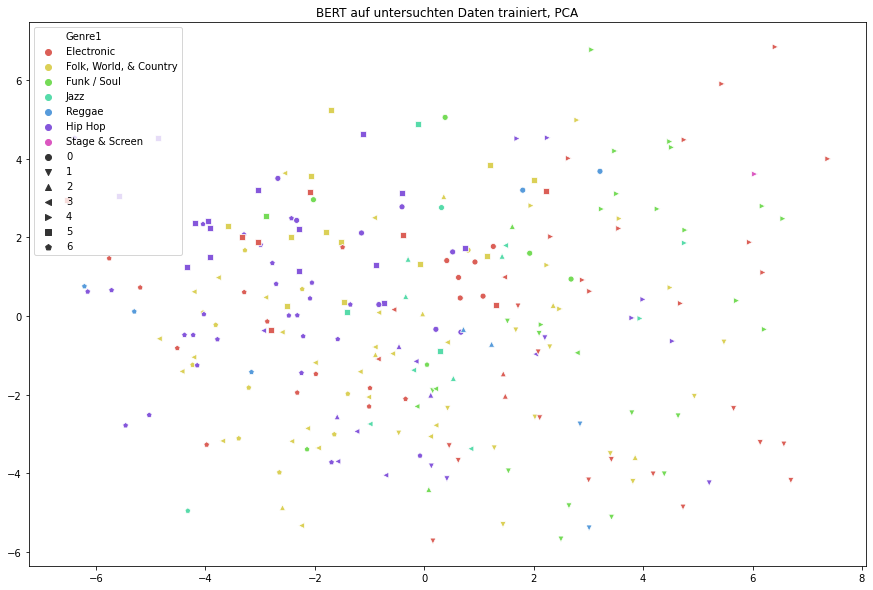

In [13]:
visualise_PCA(Y, songs.Genre1, prediction,'BERT auf untersuchten Daten trainiert, PCA','/content/bert_PCA.png')

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 254 samples in 0.001s...
[t-SNE] Computed neighbors for 254 samples in 0.018s...
[t-SNE] Computed conditional probabilities for sample 254 / 254
[t-SNE] Mean sigma: 3.631733
[t-SNE] Computed conditional probabilities in 0.046s
[t-SNE] Iteration 50: error = 47.6310043, gradient norm = 0.0000000 (50 iterations in 0.123s)
[t-SNE] Iteration 50: gradient norm 0.000000. Finished.
[t-SNE] KL divergence after 50 iterations with early exaggeration: 47.631004
[t-SNE] Iteration 100: error = 0.9171888, gradient norm = 0.0061382 (50 iterations in 0.107s)
[t-SNE] Iteration 150: error = 0.8603718, gradient norm = 0.0015434 (50 iterations in 0.077s)
[t-SNE] Iteration 200: error = 0.8479519, gradient norm = 0.0005259 (50 iterations in 0.077s)
[t-SNE] Iteration 250: error = 0.8463409, gradient norm = 0.0001696 (50 iterations in 0.082s)
[t-SNE] Iteration 300: error = 0.8459514, gradient norm = 0.0001234 (50 iterations in 0.077s)
[t-SNE] Iteration

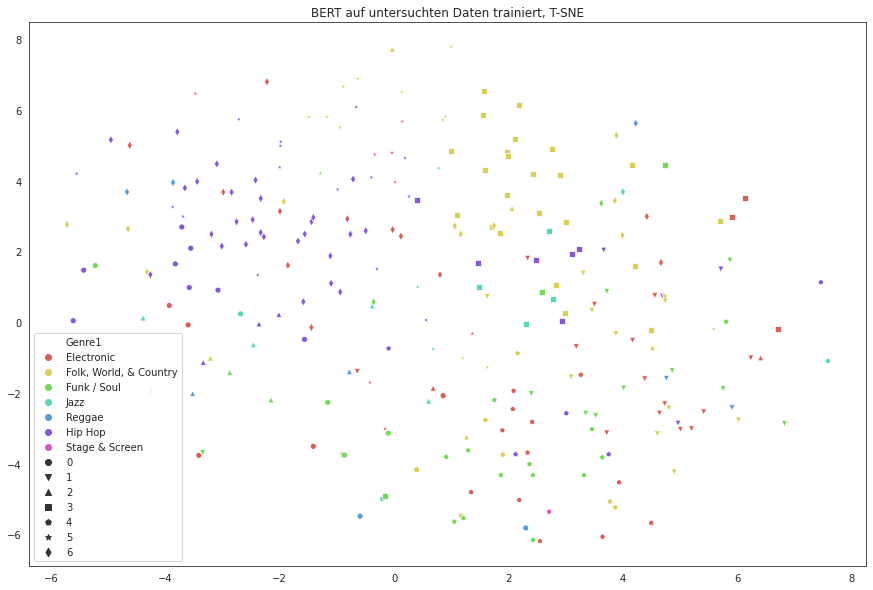

In [14]:
visualise_TSNE(X=X, hue=songs.Genre1, style=prediction,title='BERT auf untersuchten Daten trainiert, T-SNE',path='/content/bert_TSNE.png', perplexity=50)

In [161]:
songs.iloc[1]['Genre1']

'Electronic'

In [17]:
clustered_sentences = [[] for i in range(k)]
for sentence_id, cluster_id in enumerate(kmeans.labels_):
    clustered_sentences[cluster_id].append(list(songs.stemmed_text)[sentence_id])
freq_list=[]
for i, cluster in enumerate(clustered_sentences):
    freqs = {}

    for j in cluster:
       
        indx = list(songs.stemmed_text).index(j)
        topic = songs.iloc[indx]['Genre1']
        if not topic in freqs:
            freqs[topic] = 1
        else:
            freqs[topic] +=1

    freq_list.append(freqs)

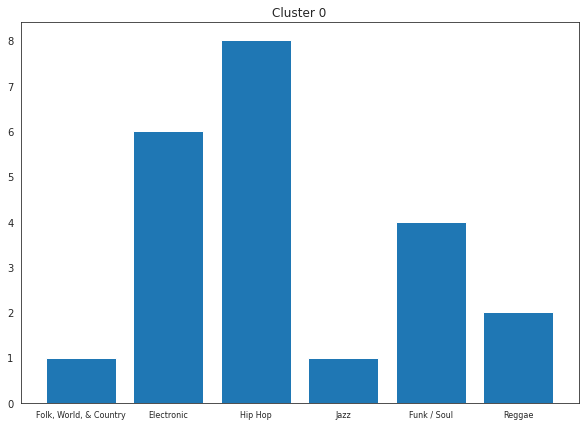

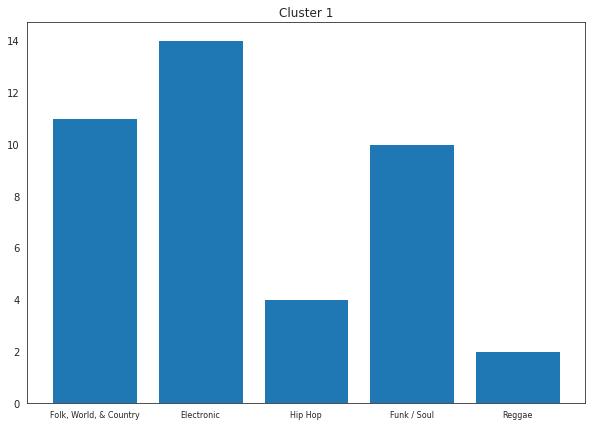

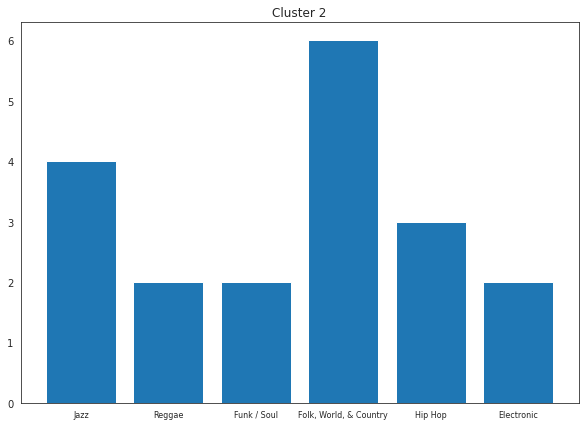

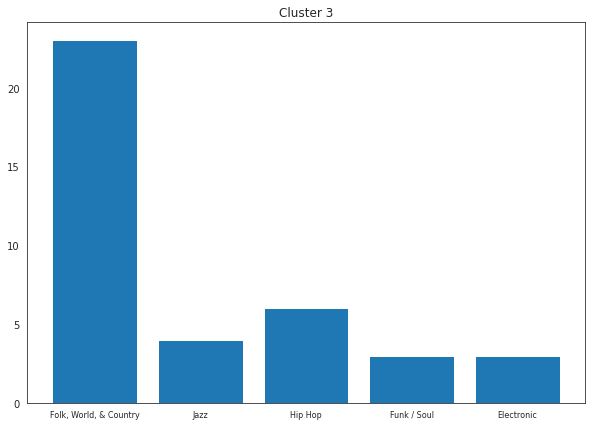

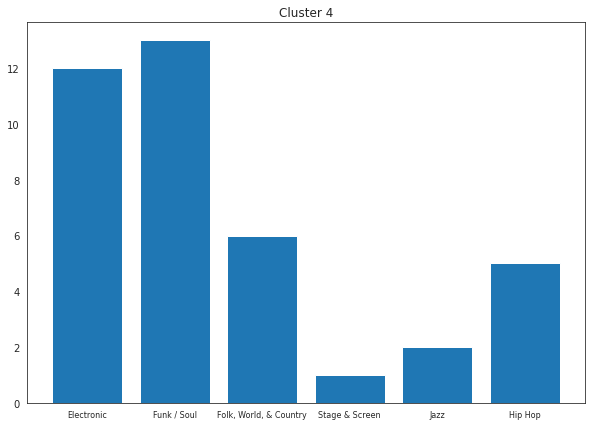

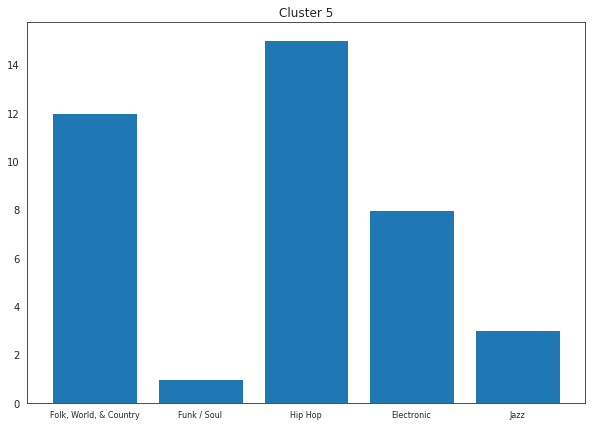

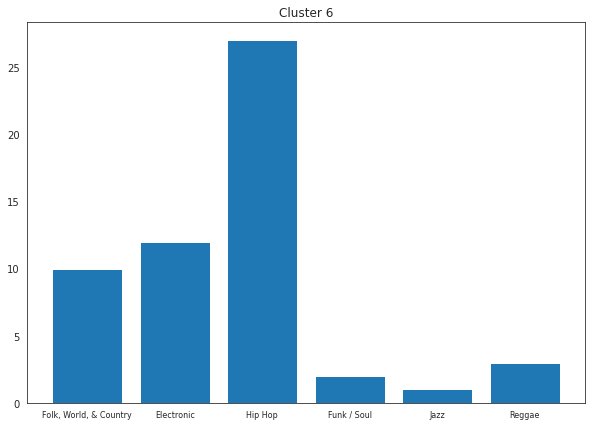

In [20]:
# häufigste Wörter pro Cluster
def hist(freqs):
    i = 0
    for dic in freqs:
        plt.figure(figsize=(10,7))
        plt.bar(list(dic.keys()),dic.values())
        plt.xticks(fontsize=8)
        plt.title('Cluster '+str(i))
        plt.savefig('/content/bert_kmeans_genres_in_cluster'+str(i)+'.png')
        plt.show()
        i +=1

hist(freq_list)

In [23]:
df = pd.DataFrame()
df['Genre'] = songs.Genre1
df['predicted'] = prediction
genre_group = pd.DataFrame(df.groupby('Genre')['predicted'].apply(lambda x: x.value_counts()))
genre_group

predicted
Genre                              
Electronic             1         14
                       6         12
                       4         12
                       5          8
                       0          6
                       3          3
                       2          2
Folk, World, & Country 3         23
                       5         12
                       1         11
                       6         10
                       4          6
                       2          6
                       0          1
Funk / Soul            4         13
                       1         10
                       0          4
                       3          3
                       6          2
                       2          2
                       5          1
Hip Hop                6         27
                       5         15
                       0          8
                       3          6
                       4          5
                       1          4
                       2          3
Jazz                   3          4
                       2          4
                       5          3
                       4          2
                       6          1
                       0          1
Reggae                 6          3
                       2          2
                       1          2
                       0          2
Stage & Screen         4          1

In [22]:
pred_group = pd.DataFrame(df.groupby('predicted')['Genre'].apply(lambda x: x.value_counts()))
pred_group

Genre
predicted                              
0         Hip Hop                     8
          Electronic                  6
          Funk / Soul                 4
          Reggae                      2
          Jazz                        1
          Folk, World, & Country      1
1         Electronic                 14
          Folk, World, & Country     11
          Funk / Soul                10
          Hip Hop                     4
          Reggae                      2
2         Folk, World, & Country      6
          Jazz                        4
          Hip Hop                     3
          Funk / Soul                 2
          Electronic                  2
          Reggae                      2
3         Folk, World, & Country     23
          Hip Hop                     6
          Jazz                        4
          Funk / Soul                 3
          Electronic                  3
4         Funk / Soul                13
          Electronic                 12
          Folk, World, & Country      6
          Hip Hop                     5
          Jazz                        2
          Stage & Screen              1
5         Hip Hop                    15
          Folk, World, & Country     12
          Electronic                  8
          Jazz                        3
          Funk / Soul                 1
6         Hip Hop                    27
          Electronic                 12
          Folk, World, & Country     10
          Reggae                      3
          Funk / Soul                 2
          Jazz                        1

## Hierarchisches Clustering

In [24]:
def linkage_matrix(n_samples, children, distances):
    """
    create a linkage matrix for the dendogram method in scipy
    n_samples: int, number of samples
    children: list of lists, clustered data points (should be 2)
    distances: list of distances between nodes
    """
    # Create linkage matrix
    

    # create the counts of samples under each node
    counts = np.zeros(children.shape[0])
    for i, merge in enumerate(children):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    return np.column_stack([children, distances, counts]).astype(float)

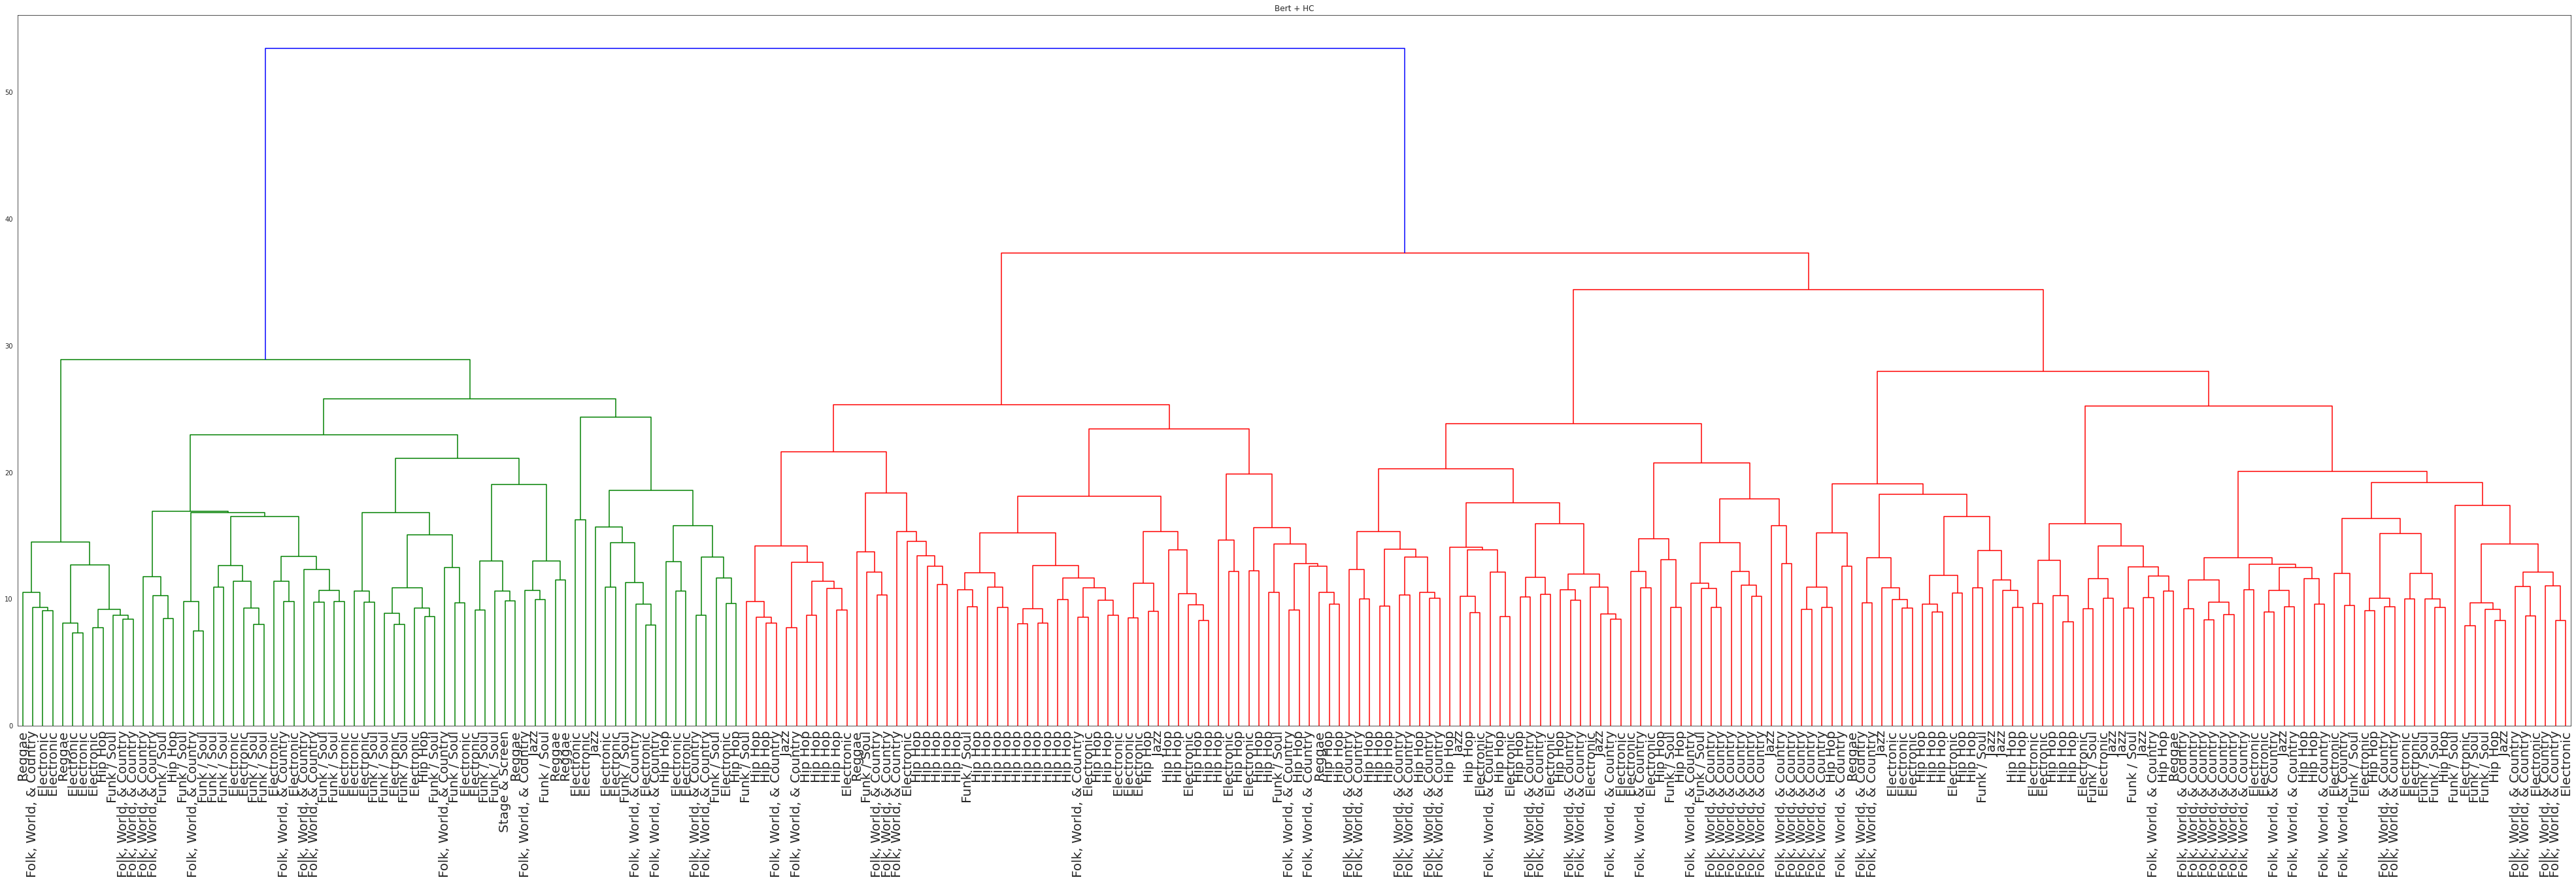

In [29]:
model = AgglomerativeClustering(n_clusters=None, distance_threshold=0).fit(X)
link_matrix = linkage_matrix(X.shape[0], model.children_, model.distances_)
plt.figure(figsize=(70,20))
plt.title('Bert + HC')
dendrogram(link_matrix, labels = (songs.Genre1.values), leaf_font_size=20);
plt.savefig('/content/bert_HC.png', bbox_inches = "tight")

In [39]:
import random
Y = random.sample(list(X), 100)

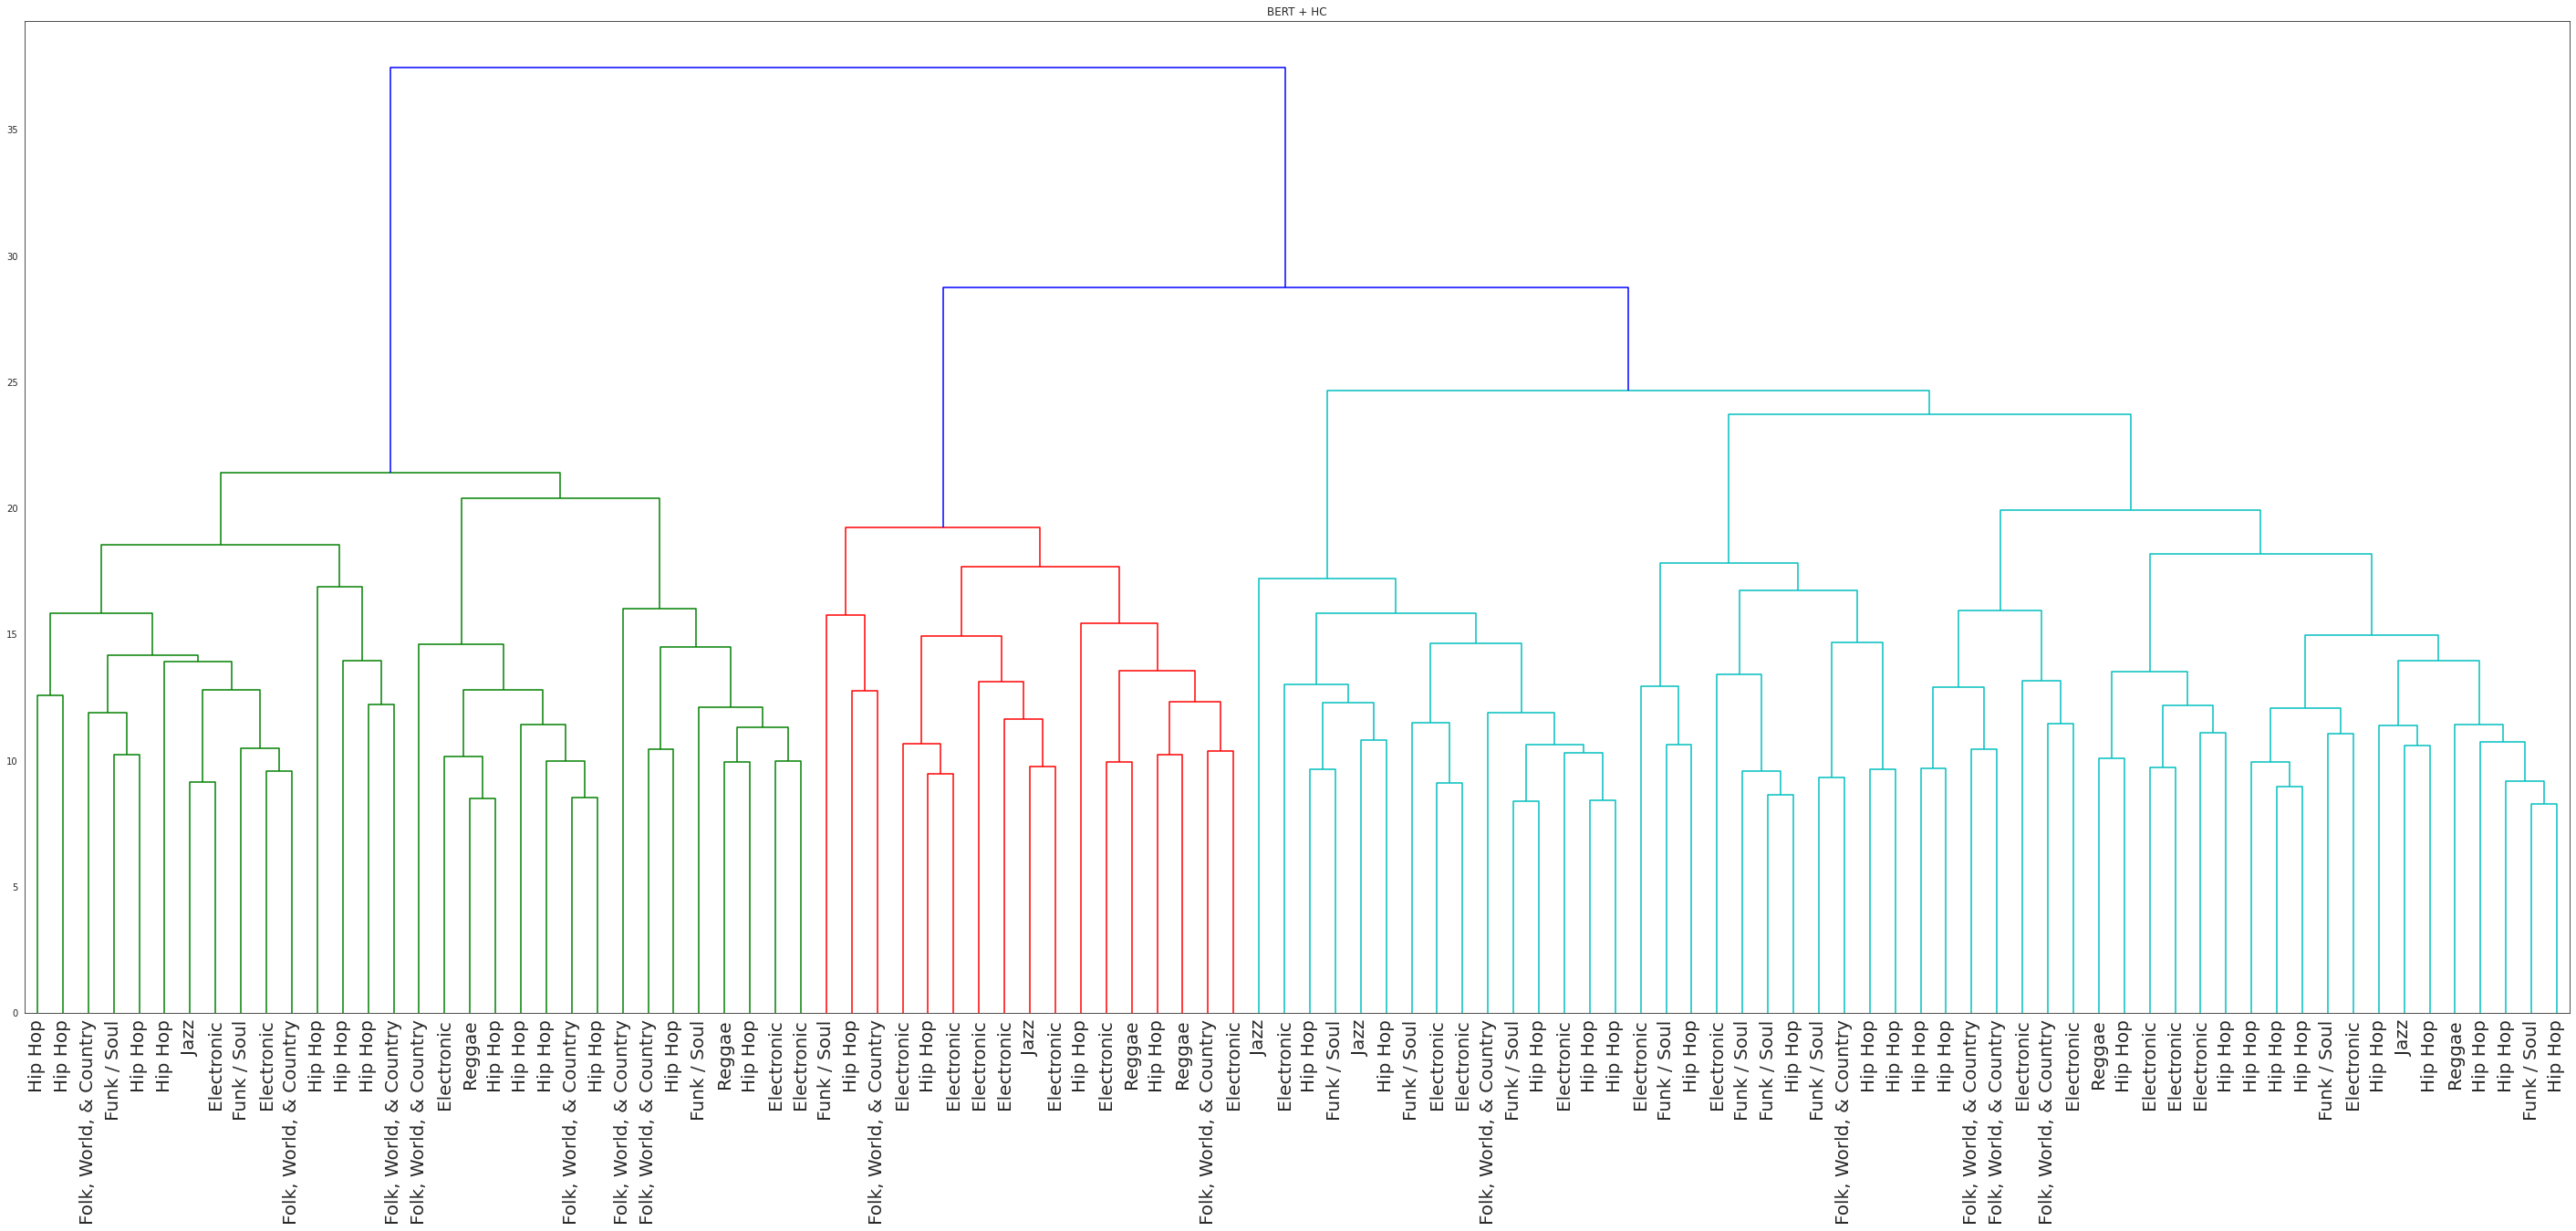

In [40]:
model = AgglomerativeClustering(n_clusters=None, distance_threshold=0).fit(Y)
link_matrix = linkage_matrix(len(Y), model.children_, model.distances_)
plt.figure(figsize=(50,20))
plt.title('BERT + HC')
dendrogram(link_matrix, labels = (songs.Genre1.values), leaf_font_size=20);
plt.savefig('/content/bert_HC_sample.png', bbox_inches = "tight")